In [1]:
import pandas as pd
import numpy as np
import math
import sys
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix,csr_matrix,eye,bmat
from scipy.sparse.linalg import eigs,inv,gmres
from scipy.stats import norm,spearmanr
from scipy.interpolate import UnivariateSpline
from collections import defaultdict
import itertools
import seaborn as sns
import pickle
import multiprocessing
sns.set_style('whitegrid')
%matplotlib inline

In [2]:
data = pd.read_csv('./../data/round.csv')
data = data.loc[data['Permanent_Tournament_#']!=470] ## this is the match play championship, no round scores available

In [3]:
data.head(3)

,Tournament_Year,Permanent_Tournament_#,Course_#,Player_Number,Player_Name,Round_Number,Round_Score,End_of_Event_Pos._(text),Event_Name,Strokes_In_Tournament,Rounds_In_Tournament,Finishing_Position
0,2003,16,656,1320,"Estes, Bob",1,66,T6,Mercedes Championships,271.0,4.0,0.208333
1,2003,16,656,1361,"Forsman, Dan",1,69,T21,Mercedes Championships,279.0,4.0,0.611111
2,2003,16,656,1761,"Mattiace, Len",1,75,24,Mercedes Championships,280.0,4.0,0.666667


In [4]:
data.shape

(257759, 12)

In [5]:
data.tail(3)

,Tournament_Year,Permanent_Tournament_#,Course_#,Player_Number,Player_Name,Round_Number,Round_Score,End_of_Event_Pos._(text),Event_Name,Strokes_In_Tournament,Rounds_In_Tournament,Finishing_Position
259740,2016,60,688,34360,"Reed, Patrick",4,70,T24,TOUR Championship,283.0,4.0,0.844828
259741,2016,60,688,37455,"Kim, Si Woo",4,65,T10,TOUR Championship,278.0,4.0,0.413793
259742,2016,60,688,40026,"Berger, Daniel",4,68,T15,TOUR Championship,279.0,4.0,0.534483


In [6]:
with open('./../PickleFiles/num_to_ind_round.pkl','r') as pickleFile:
    num_to_inds = pickle.load(pickleFile)

In [7]:
data.insert(5,'Player_Index',[num_to_inds[num] for num in data.Player_Number])

_Strokes Gained To The Field_

In [17]:
field_perf = data.groupby(['Tournament_Year','Permanent_Tournament_#','Round_Number','Course_#']).Round_Score.mean().to_dict()

In [18]:
data.insert(len(data.columns),'Field_Performance',[field_perf[tuple(tup)] 
                                                   for tup in data[['Tournament_Year','Permanent_Tournament_#',
                                                                    'Round_Number','Course_#']].values.tolist()])

In [19]:
data.insert(len(data.columns),'Strokes_Gained_To_The_Field',data.Field_Performance-data.Round_Score)

In [20]:
data.Strokes_Gained_To_The_Field.describe()

count    2.577590e+05
mean    -2.877908e-17
std      2.944108e+00
min     -1.965625e+01
25%     -1.830769e+00
50%      1.527778e-01
75%      1.985915e+00
max      1.208571e+01
Name: Strokes_Gained_To_The_Field, dtype: float64

In [21]:
data.sort_values('Strokes_Gained_To_The_Field',ascending=False).head(3)

,Tournament_Year,Permanent_Tournament_#,Course_#,Player_Number,Player_Name,Player_Index,Round_Number,Round_Score,End_of_Event_Pos._(text),Event_Name,Strokes_In_Tournament,Rounds_In_Tournament,Finishing_Position,Tournament_Group,Field_Performance,Strokes_Gained_To_The_Field
204812,2013,28,789,10809,"Furyk, Jim",21,2,59,3,BMW Championship,271.0,4.0,0.042857,123,71.085714,12.085714
229372,2015,473,8,27141,"Holmes, J.B.",453,1,62,2,World Golf Championships-Cadillac Championship,280.0,4.0,0.027397,139,73.356164,11.356164
13487,2003,56,56,1706,"Love III, Davis",198,1,63,1,The INTERNATIONAL,270.0,4.0,0.007194,7,74.115108,11.115108


In [8]:
tups = data.drop_duplicates(['Tournament_Year','Permanent_Tournament_#'])[['Tournament_Year','Permanent_Tournament_#']].values.tolist()
tournament_groups = {tuple(tup):u/4 for u,tup in enumerate(tups)}

In [9]:
data.insert(len(data.columns),'Tournament_Group',[tournament_groups[tuple(tup)] 
                                                  for tup in data[['Tournament_Year','Permanent_Tournament_#']].values.tolist()])

In [10]:
data.head(3)

,Tournament_Year,Permanent_Tournament_#,Course_#,Player_Number,Player_Name,Player_Index,Round_Number,Round_Score,End_of_Event_Pos._(text),Event_Name,Strokes_In_Tournament,Rounds_In_Tournament,Finishing_Position,Tournament_Group
0,2003,16,656,1320,"Estes, Bob",0,1,66,T6,Mercedes Championships,271.0,4.0,0.208333,0
1,2003,16,656,1361,"Forsman, Dan",1,1,69,T21,Mercedes Championships,279.0,4.0,0.611111,0
2,2003,16,656,1761,"Mattiace, Len",2,1,75,24,Mercedes Championships,280.0,4.0,0.666667,0


In [22]:
player_perfs = data.groupby(['Tournament_Group','Player_Index'],as_index=False).agg({'Round_Number':'count',
                                                       'Strokes_Gained_To_The_Field':'sum'})
player_perfs = {tuple(tup[0:2]):tup[2:] for tup in player_perfs.values.tolist()}

In [23]:
for key in sorted(player_perfs,key=player_perfs.get,reverse=True)[0:10]:
    print key,player_perfs[key]

(24.0, 162.0) [17.0, 47.959821348632985]
(93.0, 711.0) [17.0, 41.779813263631695]
(12.0, 87.0) [17.0, 28.928805245529347]
(59.0, 22.0) [17.0, 28.908535495163534]
(0.0, 10.0) [17.0, 28.13712329337332]
(24.0, 14.0) [17.0, 27.156669400967203]
(0.0, 1.0) [17.0, 18.82462329337332]
(24.0, 183.0) [17.0, 18.156669400967203]
(59.0, 267.0) [17.0, 18.014718290862447]
(93.0, 441.0) [17.0, 15.444530061281924]


In [24]:
len(player_perfs)

41765

In [25]:
def my_norm(x,BETA):
    return norm.pdf(x,0,BETA)/norm.pdf(0,0,BETA)

In [26]:
def take_weighted_ave(a,beta,window_size=35):
    if not a:
        return np.nan
    counts = np.array([count for count,total in a[max(0,len(a)-window_size):]])
    if counts.sum()==0:
        return np.nan
    means = [total/count if count!=0 else 0 for count,total in a[max(0,len(a)-window_size):]]
    x = list(itertools.chain.from_iterable([[means[j]]*int(counts[j]) for j in range(len(counts))]))
    weights = list(itertools.chain.from_iterable([[my_norm(len(counts)-j-1,beta)]*int(counts[j]) 
                                                  for j in range(len(counts))]))
    return np.dot(x,weights)/np.sum(weights)

In [67]:
take_weighted_ave([(7,3.2),(8,7.6),(9,3.4),(10,2.1),(0.0,0),(0,0),(0,np.nan),(1,5.)],1.3)

4.5908045140793075

In [98]:
n_tournament_groups = len(pd.unique(data.Tournament_Group))
players = range(len(num_to_inds))

Training

In [28]:
def run_a_beta(betas):
    pearsons,spearmans = [],[]
    for BETA in betas:
        A = np.array([[take_weighted_ave([player_perfs[(tournament_group,player_ind)] 
                                          if (tournament_group,player_ind) in player_perfs else (0.,0.)
                                          for tournament_group in range(i)],BETA)
                       for i in range(100)]
                      for player_ind in players])

        x,y = [],[]
        for (year,tourn),df in data.groupby(['Tournament_Year','Permanent_Tournament_#'],sort=False):
            if tournament_groups[(year,tourn)]>=100:
                continue
            ratings = A[pd.unique(df.Player_Index),tournament_groups[(year,tourn)]]
            rankings = pd.Series(ratings[~np.isnan(ratings)]).rank(ascending=False,pct=True).values
            finishing_pos = df.groupby('Player_Index').Finishing_Position.mean().to_dict()
            finishing_pos = [finishing_pos[ind] for ind in pd.unique(df.Player_Index)[~np.isnan(ratings)]]
            finishing_pos = pd.Series(finishing_pos).rank(ascending=True,pct=True).values
            x.extend(rankings.tolist())
            y.extend(finishing_pos.tolist())

        pearson,spearman = np.corrcoef(x,y)[0,1],spearmanr(x,y)[0]
        print BETA,pearson,spearman
        pearsons.append(pearson)
        spearmans.append(spearman)
    return (betas,pearsons,spearmans)

In [29]:
def partition (lst, n):
    return [lst[i::n] for i in xrange(n)]

In [30]:
num_cores = 16
slices = partition(np.linspace(1,27,27),num_cores)
pool = multiprocessing.Pool(num_cores)
results = pool.map(run_a_beta, slices)
pool.close()

8.0 0.198512853911 0.198391817873
16.0 0.202051277623 0.201923304233
1.0 0.162257780022 0.162153712427
9.0 0.199687491691 0.199565112474
13.0 0.202035268025 0.20190865809
11.0 0.201383791683 0.201258406928
7.0 0.196854880312 0.196734852944
15.0 0.202049444653 0.201924052673
4.0 0.187094744161 0.186982321401
2.0 0.17463177483 0.174518244759
14.0 0.202182515771 0.202054011429
6.0 0.194289720757 0.194166546471
3.0 0.181818461225 0.181697570907
12.0 0.201690791059 0.201559830655
5.0 0.191175150272 0.191061396974
10.0 0.20056016422 0.200435030728
24.026.017.025.021.027.023.019.020.018.022.0 0.200779054409 0.200655598699
 0.200474194902 0.200354577248
 0.202092862039 0.20196749958
 0.200603607655 0.200481328854
 0.201418594154 0.201293817406
 0.200391058899 0.200271963398
 0.201014088225 0.200890197379
 0.201813830854 0.201686071102
 0.201629257593 0.201504398516
 0.202025231851 0.201900680507
 0.201228048313 0.201103278173


In [31]:
results = sum([zip(*results[i]) for i in range(len(results))],[])
results = sorted(results)

In [32]:
max(results,key=lambda x: x[1]),max(results,key=lambda x: x[2])

((14.0, 0.20218251577116753, 0.20205401142919804),
 (14.0, 0.20218251577116753, 0.20205401142919804))

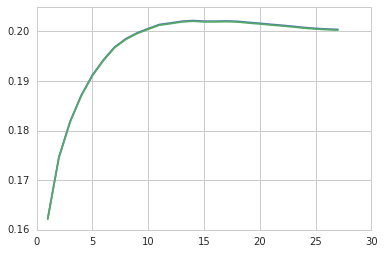

In [33]:
plt.plot([i[0] for i in results],[i[1] for i in results])
plt.plot([i[0] for i in results],[i[2] for i in results]);

Making Test Set

In [99]:
BETA = 14
A = np.array([[take_weighted_ave([player_perfs[(tournament_group,player_ind)] 
                                  if (tournament_group,player_ind) in player_perfs else (0.,0.)
                                  for tournament_group in range(i)],BETA)
               for i in range(n_tournament_groups)]
              for player_ind in players])

In [100]:
x,y,tourns,years,players = [],[],[],[],[]
for (year,tourn),df in data.groupby(['Tournament_Year','Permanent_Tournament_#'],sort=False):
    if tournament_groups[(year,tourn)]<100:
        continue
    ratings = A[pd.unique(df.Player_Index),tournament_groups[(year,tourn)]]
    rankings = pd.Series(ratings[~np.isnan(ratings)]).rank(ascending=False,pct=True).values
    finishing_pos = df.groupby('Player_Index').Finishing_Position.mean().to_dict()
    finishing_pos = [finishing_pos[ind] for ind in pd.unique(df.Player_Index)[~np.isnan(ratings)]]
    finishing_pos = pd.Series(finishing_pos).rank(ascending=True,pct=True).values
    x.extend(rankings.tolist())
    y.extend(finishing_pos.tolist())
    tourns.extend([tourn]*len(rankings))
    years.extend([year]*len(rankings))
    players.extend(pd.unique(df.Player_Index)[~np.isnan(ratings)].tolist())

In [101]:
SGTTF_Test = pd.DataFrame({'x':x,'y':y,'tourn':tourns,'year':years,'player':players})

In [102]:
SGTTF_Test.head(4)

,player,tourn,x,y,year
0,152,32,0.965278,0.881944,2011
1,155,32,0.888889,0.107639,2011
2,0,32,0.500000,0.291667,2011
3,48,32,0.881944,0.621528,2011


In [103]:
len(x),len(y)

(28510, 28510)

In [39]:
year_inds = {value:key[0] for key,value in tournament_groups.iteritems()}
first_group_years = {}
for group in sorted(year_inds):
    if year_inds[group] not in first_group_years:
        first_group_years[year_inds[group]] = group
y_,x_ = zip(*sorted(first_group_years.items()))
f = UnivariateSpline(x_,y_)
year_vals = f(np.arange(n_tournament_groups))
year_vals = map(int,map(__builtins__.round,year_vals))

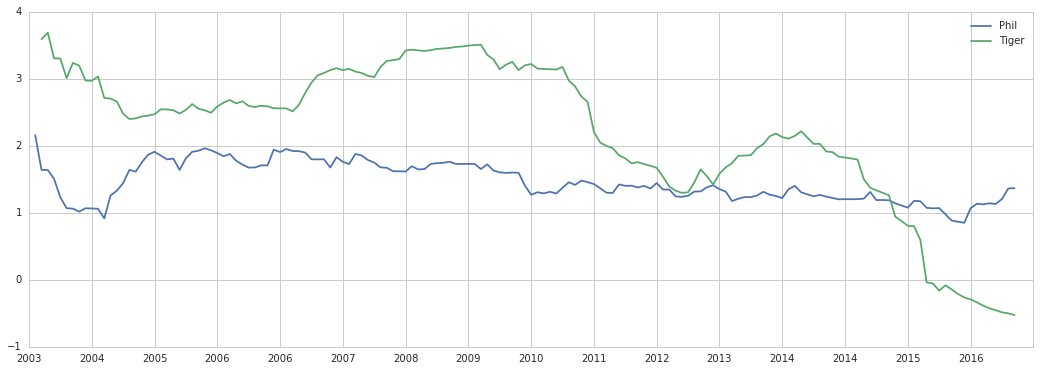

In [40]:
plt.figure(figsize=(18,6))
plt.plot(range(n_tournament_groups),A[162,:],label='Phil')
plt.plot(range(n_tournament_groups),A[277,:],label='Tiger')
plt.xticks(range(n_tournament_groups)[::10],year_vals[::10])
plt.legend();

Park-Newman Ranking Method

In [8]:
def alpha(A,a):
    w = eigs(A,k=1,which='LM',return_eigenvectors=False)
    if w.imag>0:
        print w
    return a/w[0].real

def solve(W,a):
    alpha_ = alpha(W,a)
    w = np.dot(np.linalg.inv(np.eye(W.shape[0])-alpha_*W),W.sum(1))
    
    L = W.T
    alpha_ = alpha(L,a)
    l = np.dot(np.linalg.inv(np.eye(L.shape[0])-alpha_*L),L.sum(1))
               
    ratings = w-l
    ratings[np.logical_and(W.sum(1)==0,L.sum(1)==0)] = np.nan
    return ratings

In [11]:
n_players = len(pd.unique(data.Player_Index))

In [33]:
A = np.zeros((n_players,n_players))
ratings = None
x,y = [],[]
a = .8
for (year,tourn_group),df in data.groupby(['Tournament_Year','Tournament_Group'],sort=False):
    print (year,tourn_group)
    if ratings is not None:
        for tournament,df_ in df.groupby(['Permanent_Tournament_#']):
            current_ratings = ratings[pd.unique(df_.Player_Index)]
            rankings = pd.Series(current_ratings[~np.isnan(current_ratings)]).rank(ascending=False,pct=True)
            finishing_pos = df_.groupby('Player_Index').Finishing_Position.mean().to_dict()
            finishing_pos = [finishing_pos[ind] for ind in pd.unique(df_.Player_Index)[~np.isnan(current_ratings)]]
            finishing_pos = pd.Series(finishing_pos).rank(ascending=True,pct=True).values
            x.extend(rankings.tolist())
            y.extend(finishing_pos.tolist())
    for (course,round),df_ in df.groupby(['Course_#','Round_Number']):
        df_sorted = df_.sort_values('Round_Score')
        for row_ind in range(len(df_)-1):
            A[df_sorted.iloc[row_ind].Player_Index,df_sorted.iloc[row_ind+1:].Player_Index.values] += 1.0
    
    ratings = solve(A,a)

(2003, 0)
(2003, 1)
(2003, 2)
(2003, 3)
(2003, 4)
(2003, 5)
(2003, 6)
(2003, 7)
(2003, 8)
(2003, 9)
(2003, 10)
(2003, 11)
(2004, 11)
(2004, 12)
(2004, 13)
(2004, 14)
(2004, 15)
(2004, 16)
(2004, 17)
(2004, 18)
(2004, 19)
(2004, 20)
(2004, 21)
(2004, 22)
(2004, 23)
(2005, 23)
(2005, 24)
(2005, 25)
(2005, 26)
(2005, 27)
(2005, 28)
(2005, 29)
(2005, 30)
(2005, 31)
(2005, 32)
(2005, 33)
(2005, 34)
(2005, 35)
(2006, 35)
(2006, 36)
(2006, 37)
(2006, 38)
(2006, 39)
(2006, 40)
(2006, 41)
(2006, 42)
(2006, 43)
(2006, 44)
(2006, 45)
(2006, 46)
(2007, 47)
(2007, 48)
(2007, 49)
(2007, 50)
(2007, 51)
(2007, 52)
(2007, 53)
(2007, 54)
(2007, 55)
(2007, 56)
(2007, 57)
(2007, 58)
(2008, 58)
(2008, 59)
(2008, 60)
(2008, 61)
(2008, 62)
(2008, 63)
(2008, 64)
(2008, 65)
(2008, 66)
(2008, 67)
(2008, 68)
(2008, 69)
(2008, 70)
(2009, 70)
(2009, 71)
(2009, 72)
(2009, 73)
(2009, 74)
(2009, 75)
(2009, 76)
(2009, 77)
(2009, 78)
(2009, 79)
(2009, 80)
(2009, 81)
(2010, 81)
(2010, 82)
(2010, 83)
(2010, 84)
(2010, 85

In [34]:
len(x),len(y)

(78669, 78669)

In [35]:
np.corrcoef(x,y)[0,1],spearmanr(x,y)[0]

(0.15684572919612524, 0.15676058380185326)

More Generalized To Take into account Margin of win or loss

In [14]:
def solve(A,G,a):
    alpha_ = alpha(A,a)
    w = np.dot(np.linalg.inv(np.eye(A.shape[0])-alpha_*A),A.sum(1))
    
    g = np.dot(np.linalg.inv(np.eye(G.shape[0])-alpha_*G),G.sum(1))
               
    ratings = w/g
    ratings[g<1] = np.nan
    return ratings

In [43]:
A,G = np.zeros((n_players,n_players)),np.zeros((n_players,n_players))
ratings = None
x,y = [],[]
a = .9
for (year,tourn_group),df in data.groupby(['Tournament_Year','Tournament_Group'],sort=False):
    print (year,tourn_group)
    if ratings is not None:
        for tournament,df_ in df.groupby(['Permanent_Tournament_#']):
            current_ratings = ratings[pd.unique(df_.Player_Index)]
            rankings = pd.Series(current_ratings[~np.isnan(current_ratings)]).rank(ascending=False,pct=True)
            finishing_pos = df_.groupby('Player_Index').Finishing_Position.mean().to_dict()
            finishing_pos = [finishing_pos[ind] for ind in pd.unique(df_.Player_Index)[~np.isnan(current_ratings)]]
            finishing_pos = pd.Series(finishing_pos).rank(ascending=True,pct=True).values
            x.extend(rankings.tolist())
            y.extend(finishing_pos.tolist())
    for (course,round),df_ in df.groupby(['Course_#','Round_Number']):
        A[np.ix_(df_.Player_Index.values,df_.Player_Index.values)] += \
            np.outer(1/df_.Round_Score.values.astype(float),df_.Round_Score.values)
        G[np.ix_(df_.Player_Index.values,df_.Player_Index.values)] += 1.0
    
    ratings = solve(A,G,a)

(2003, 0)
(2003, 1)
(2003, 2)
(2003, 3)
(2003, 4)
(2003, 5)
(2003, 6)
(2003, 7)
(2003, 8)
(2003, 9)
(2003, 10)
(2003, 11)
(2004, 11)
(2004, 12)
(2004, 13)
(2004, 14)
(2004, 15)
(2004, 16)
(2004, 17)
(2004, 18)
(2004, 19)
(2004, 20)
(2004, 21)
(2004, 22)
(2004, 23)
(2005, 23)
(2005, 24)
(2005, 25)
(2005, 26)
(2005, 27)
(2005, 28)
(2005, 29)
(2005, 30)
(2005, 31)
(2005, 32)
(2005, 33)
(2005, 34)
(2005, 35)
(2006, 35)
(2006, 36)
(2006, 37)
(2006, 38)
(2006, 39)
(2006, 40)
(2006, 41)
(2006, 42)
(2006, 43)
(2006, 44)
(2006, 45)
(2006, 46)
(2007, 47)
(2007, 48)
(2007, 49)
(2007, 50)
(2007, 51)
(2007, 52)
(2007, 53)
(2007, 54)
(2007, 55)
(2007, 56)
(2007, 57)
(2007, 58)
(2008, 58)
(2008, 59)
(2008, 60)
(2008, 61)
(2008, 62)
(2008, 63)
(2008, 64)
(2008, 65)
(2008, 66)
(2008, 67)
(2008, 68)
(2008, 69)
(2008, 70)
(2009, 70)
(2009, 71)
(2009, 72)
(2009, 73)
(2009, 74)
(2009, 75)
(2009, 76)
(2009, 77)
(2009, 78)
(2009, 79)
(2009, 80)
(2009, 81)
(2010, 81)
(2010, 82)
(2010, 83)
(2010, 84)
(2010, 85

In [44]:
len(x),len(y)

(78669, 78669)

In [45]:
np.corrcoef(x,y)[0,1],spearmanr(x,y)[0]

(0.17751482307337862, 0.1774347926236042)

Generalized for both time and margin.

Training

In [12]:
def alpha(A,a):
    w = eigs(A,k=1,which='LR',return_eigenvectors=False)
    return a/w[0].real

def solve(A,G,a,min_g,x_guess=None,x_guess1=None):
    
    alpha_ = alpha(A,a)
    SA = eye(A.shape[0],format='csc')-alpha_*A
    w_a = gmres(SA,A.sum(1),x0=x_guess)[0]
    
    alpha_ = alpha(G,a)
    SG = eye(G.shape[0],format='csc')-alpha_*G
    w_g = gmres(SG,G.sum(1),x0=x_guess1)[0]
    
    solve.w_a = w_a
    solve.w_g = w_g
    
    ratings = w_a/w_g
    ratings[w_g<min_g] = np.nan
    return ratings[-n_players:]

In [13]:
sys.path.append('./../ProcessingPipeline')
from makeBigRoundsMat import return_mats

In [14]:
def run(a,BETA,m,r):
    A,G = return_mats(BETA,m,r)
    window_size = 35
    x,y = [],[]
    ratings = None
    for tournament_group in range(100):
        if ratings is not None:
            df = data[data.Tournament_Group==tournament_group]
            for tournament,df_ in df.groupby(['Permanent_Tournament_#']):
                current_ratings = ratings[pd.unique(df_.Player_Index)]
                rankings = pd.Series(current_ratings[~np.isnan(current_ratings)]).rank(ascending=False,pct=True)
                finishing_pos = df_.groupby('Player_Index').Finishing_Position.mean().to_dict()
                finishing_pos = [finishing_pos[ind] for ind in pd.unique(df_.Player_Index)[~np.isnan(current_ratings)]]
                finishing_pos = pd.Series(finishing_pos).rank(ascending=True,pct=True).values
                x.extend(rankings.tolist())
                y.extend(finishing_pos.tolist())

        lower = n_players*max(0,tournament_group-window_size+1)
        upper = n_players*(tournament_group+1)
        if tournament_group==0:
            ratings = solve(A[lower:upper,lower:upper],G[lower:upper,lower:upper],a,1)
        else:
            w_a_approx = np.append(solve.w_a[0 if tournament_group<window_size else n_players:],solve.w_a[-n_players:])
            w_g_approx = np.append(solve.w_g[0 if tournament_group<window_size else n_players:],solve.w_g[-n_players:])
            ratings = solve(A[lower:upper,lower:upper],G[lower:upper,lower:upper],a,1,w_a_approx,w_g_approx)
    print a,BETA,m,r,np.corrcoef(x,y)[0,1],spearmanr(x,y)[0]

In [15]:
alphas = np.linspace(.9,.99,3)
betas = np.linspace(7,18,5)
ms = np.linspace(.001,.02,3)
rs = np.linspace(.001,.02,3)

In [16]:
for a,BETA,m,r in itertools.product(alphas,betas,ms,rs):
    run(a,BETA,m,r)

0.9 7.0 0.001 0.001 -0.202223741015 -0.202076393533
0.9 7.0 0.001 0.0105 -0.202195190581 -0.20204861342
0.9 7.0 0.001 0.02 -0.20224054379 -0.202093312313
0.9 7.0 0.0105 0.001 -0.202201242193 -0.202054355149
0.9 7.0 0.0105 0.0105 -0.202202519411 -0.202055773994
0.9 7.0 0.0105 0.02 -0.202236589936 -0.202088900186
0.9 7.0 0.02 0.001 -0.202185222305 -0.202038633606
0.9 7.0 0.02 0.0105 -0.202220012829 -0.202073369477
0.9 7.0 0.02 0.02 -0.20223587833 -0.20208859218
0.9 9.75 0.001 0.001 -0.204150579859 -0.20400709229
0.9 9.75 0.001 0.0105 -0.204146930435 -0.204003353078
0.9 9.75 0.001 0.02 -0.20413914495 -0.203995878124
0.9 9.75 0.0105 0.001 -0.204142618311 -0.203998926567
0.9 9.75 0.0105 0.0105 -0.204127619528 -0.203984078016
0.9 9.75 0.0105 0.02 -0.204154688329 -0.204011414793
0.9 9.75 0.02 0.001 -0.204136997407 -0.203993600111
0.9 9.75 0.02 0.0105 -0.204128908378 -0.203985958769
0.9 9.75 0.02 0.02 -0.204138044444 -0.203994638067
0.9 12.5 0.001 0.001 -0.204217360924 -0.204074848592
0.9 12.5

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in divide


In [42]:
alphas = [.99]
betas = np.linspace(10,14,5)
ms = [0.0105]
rs = np.linspace(.02,.08,3)

In [43]:
for a,BETA,m,r in itertools.product(alphas,betas,ms,rs):
    run(a,BETA,m,r)

0.99 10.0 0.0105 0.02 -0.204040608603 -0.203900349514
0.99 10.0 0.0105 0.05 -0.204099589865 -0.203958695462
0.99 10.0 0.0105 0.08 -0.204083252829 -0.203941918556
0.99 11.0 0.0105 0.02 -0.204206080235 -0.204061822335
0.99 11.0 0.0105 0.05 -0.204251368225 -0.204107975677
0.99 11.0 0.0105 0.08 -0.204151790572 -0.20401262158
0.99 12.0 0.0105 0.02 -0.204440879355 -0.204295217576
0.99 12.0 0.0105 0.05 -0.204406110178 -0.204262656489
0.99 12.0 0.0105 0.08 -0.204404674454 -0.20426446516
0.99 13.0 0.0105 0.02 -0.204190276097 -0.204048459697
0.99 13.0 0.0105 0.05 -0.20428879582 -0.204150191569
0.99 13.0 0.0105 0.08 -0.204324105035 -0.204186371717
0.99 14.0 0.0105 0.02 -0.20406774062 -0.20393028412
0.99 14.0 0.0105 0.05 -0.204010871744 -0.203876092684
0.99 14.0 0.0105 0.08 -0.204136062287 -0.204001346187


/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in divide


Making Test Set

In [117]:
a = .99
BETA = 12.0
m,r = 0.0105,0.02
A,G = return_mats(BETA,m,r)
x,y,tourns,years,players = [],[],[],[],[]
window_size = 35
for tournament_group,df in data.groupby('Tournament_Group',sort=False):
    if tournament_group<99:
        continue
    if tournament_group==99:
        lower = n_players*max(0,tournament_group-window_size+1)
        upper = n_players*(tournament_group+1)
        ratings = solve(A[lower:upper,lower:upper],G[lower:upper,lower:upper],a,1)
        continue
    
    for (tournament,year),df_ in df.groupby(['Permanent_Tournament_#','Tournament_Year']):
        current_ratings = ratings[pd.unique(df_.Player_Index)]
        rankings = pd.Series(current_ratings[~np.isnan(current_ratings)]).rank(ascending=False,pct=True).values
        finishing_pos = df_.groupby('Player_Index').Finishing_Position.mean().to_dict()
        finishing_pos = [finishing_pos[ind] for ind in pd.unique(df_.Player_Index)[~np.isnan(current_ratings)]]
        finishing_pos = pd.Series(finishing_pos).rank(ascending=True,pct=True).values
        x.extend(rankings.tolist())
        y.extend(finishing_pos.tolist())
        tourns.extend([tournament]*len(rankings))
        years.extend([year]*len(rankings))
        players.extend(pd.unique(df_.Player_Index)[~np.isnan(current_ratings)].tolist())
    
    lower = n_players*max(0,tournament_group-window_size+1)
    upper = n_players*(tournament_group+1)
    w_a_approx = np.append(solve.w_a[0 if tournament_group<window_size else n_players:],solve.w_a[-n_players:])
    w_g_approx = np.append(solve.w_g[0 if tournament_group<window_size else n_players:],solve.w_g[-n_players:])
    ratings = solve(A[lower:upper,lower:upper],G[lower:upper,lower:upper],a,1,w_a_approx,w_g_approx)

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in divide


In [118]:
Network_Test = pd.DataFrame({'x':x,'y':y,'tourn':tourns,'year':years,'player':players})

In [119]:
len(Network_Test)

28507

In [120]:
len(SGTTF_Test)

28510

In [121]:
len(SGTTF_Test.merge(Network_Test,on=['tourn','year','player']))

28507

In [122]:
test_data = SGTTF_Test.merge(Network_Test,on=['tourn','year','player'],suffixes=['_sgttf','_network'])

In [123]:
test_data.head()

,player,tourn,x_sgttf,y_sgttf,year,x_network,y_network
0,152,32,0.965278,0.881944,2011,0.048611,0.881944
1,155,32,0.888889,0.107639,2011,0.152778,0.107639
2,0,32,0.500000,0.291667,2011,0.451389,0.291667
3,48,32,0.881944,0.621528,2011,0.083333,0.621528
4,159,32,0.604167,0.236111,2011,0.479167,0.236111


In [124]:
np.corrcoef(test_data.x_sgttf,test_data.y_sgttf)

array([[ 1.        ,  0.19790542],
       [ 0.19790542,  1.        ]])

In [125]:
np.corrcoef(test_data.x_network,test_data.y_network)

array([[ 1.        , -0.19431817],
       [-0.19431817,  1.        ]])

In [126]:
np.mean((test_data.x_sgttf-test_data.y_sgttf)**2)**.5

0.365248981689856

In [127]:
np.mean((test_data.x_network-test_data.y_network)**2)**.5

0.44572083149622793

In [159]:
(spearmanr(test_data.x_network,test_data.y_network)[0],
spearmanr(test_data.x_sgttf,test_data.y_network)[0])

(-0.19421011435377175, 0.19780128948788794)

In [156]:
a = test_data.sample(frac=1,replace=True)

In [157]:
np.corrcoef(a.x_sgttf,a.y_sgttf)[0,1],np.corrcoef(a.x_network,a.y_network)[0,1]

(0.19543389680637477, -0.19233709186680284)

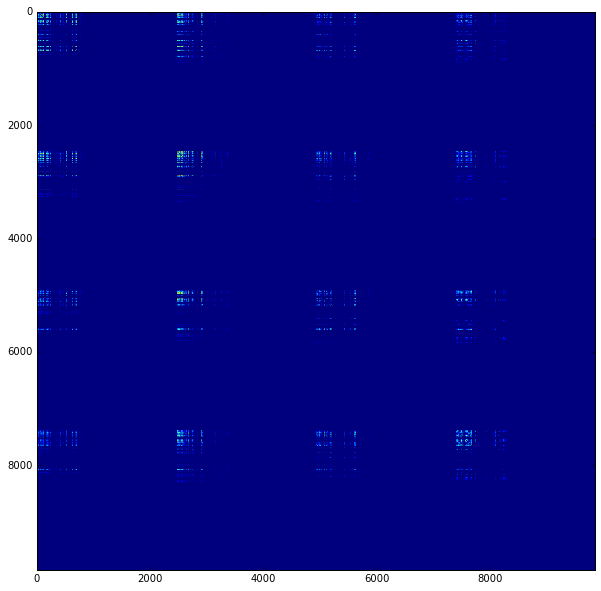

In [47]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.imshow(A[10*n_players:14*n_players,10*n_players:14*n_players].toarray());